<a href="https://colab.research.google.com/github/saikiran-18/Transaction-Fraud-Detection/blob/main/Transaction_fraud_detection_supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔹 Model Evaluation on Test Set:
Accuracy: 0.6582
Precision: 0.3311
Recall: 0.0624
F1-score: 0.1051
Confusion Matrix:
 [[9572  608]
 [4519  301]]

🔹 Feature Importances:
 Transaction_Distance       0.294841
Account_Balance            0.294127
Transaction_Amount         0.292791
Daily_Transaction_Count    0.118241
dtype: float64


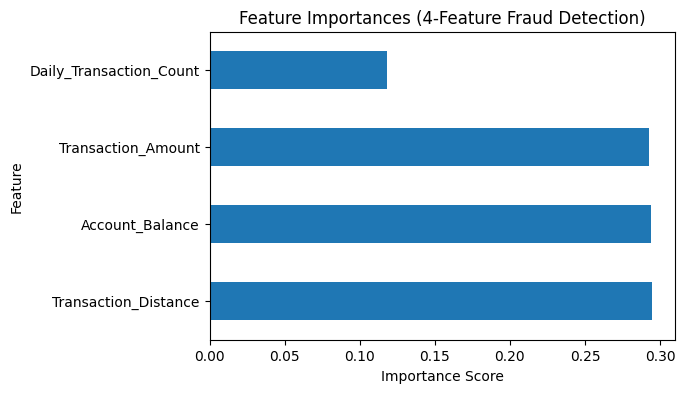

['features.pkl']

In [45]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib
import matplotlib.pyplot as plt

# --- 1. Load dataset ---
df = pd.read_csv("synthetic_fraud_dataset.csv")

# --- 2. Target column ---
y = df["Fraud_Label"]

# --- 3. Select only 4 user-knowable features ---
selected_features = [
    "Transaction_Amount",
    "Daily_Transaction_Count",
    "Account_Balance",
    "Transaction_Distance"
]

X = df[selected_features]

# --- 4. Scale features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 5. Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# --- 6. Train RandomForest with class balancing ---
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced"
)
rf_model.fit(X_train, y_train)

# --- 7. Evaluate model ---
y_pred = rf_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("🔹 Model Evaluation on Test Set:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print("Confusion Matrix:\n", cm)

# --- 8. Feature Importance ---
feat_importances = pd.Series(rf_model.feature_importances_, index=selected_features).sort_values(ascending=False)
print("\n🔹 Feature Importances:\n", feat_importances)

plt.figure(figsize=(6,4))
feat_importances.plot(kind="barh")
plt.title("Feature Importances (4-Feature Fraud Detection)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# --- 9. Save model + scaler + features for Streamlit ---
joblib.dump(rf_model, "fraud_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(selected_features, "features.pkl")


In [46]:
from sklearn.ensemble import RandomForestRegressor  # <-- import the regressor

# Features to predict Risk_Score
X_risk = df[["Transaction_Amount","Daily_Transaction_Count","Account_Balance","Transaction_Distance"]]
y_risk = df["Risk_Score"]

# Train a RandomForest regressor to predict Risk_Score
risk_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)
risk_model.fit(X_risk, y_risk)

# Save the Risk_Score predictor
import joblib
joblib.dump(risk_model, "risk_model.pkl")

print("✅ Risk_Score model trained and saved!")



✅ Risk_Score model trained and saved!


In [47]:
!pip install streamlit pyngrok


In [52]:
%%writefile app.py
import streamlit as st
import joblib
import pandas as pd
import numpy as np

# --- Load models + features ---
rf_model = joblib.load("fraud_model.pkl")       # Main fraud classifier
scaler = joblib.load("scaler.pkl")             # Scaler for features
all_features = joblib.load("features.pkl")     # Features used in training
risk_model = joblib.load("risk_model.pkl")     # Model to predict Risk_Score

# Observable features only
selected_features = [
    "Transaction_Amount",
    "Daily_Transaction_Count",
    "Account_Balance",
    "Transaction_Distance"
]

st.set_page_config(page_title="Fraud Detection App", layout="centered")
st.title("🔍 Fraud Detection System")
st.write("Enter transaction details below to check if it's Fraud or Not Fraud.")

# --- Collect user inputs with min/max limits ---
user_input = {}

user_input["Transaction_Amount"] = st.number_input(
    "Transaction_Amount",
    min_value=0.0,
    max_value=100000.0,  # adjust based on dataset
    value=100.0
)

user_input["Daily_Transaction_Count"] = st.number_input(
    "Daily_Transaction_Count",
    min_value=0,
    max_value=50,         # adjust based on dataset
    value=1
)

user_input["Account_Balance"] = st.number_input(
    "Account_Balance",
    min_value=0.0,
    max_value=1000000.0,  # adjust based on dataset
    value=5000.0
)

user_input["Transaction_Distance"] = st.number_input(
    "Transaction_Distance",
    min_value=0.0,
    max_value=10000.0,    # adjust based on dataset
    value=5.0
)

# --- Compute Risk_Score automatically ---
input_df_risk = pd.DataFrame([user_input])
risk_score = risk_model.predict(input_df_risk)[0]
user_input["Risk_Score"] = risk_score

# --- Convert to DataFrame and align with training features ---
input_df = pd.DataFrame([user_input]).reindex(columns=all_features, fill_value=0)

# --- Scale input ---
input_scaled = scaler.transform(input_df)

# --- Predict probabilities ---
probs = rf_model.predict_proba(input_scaled)[0]
fraud_prob = probs[1]

# Threshold for classification
threshold = 0.3
pred_class = 1 if fraud_prob > threshold else 0
prediction_label = "🚨 Fraud" if pred_class == 1 else "✅ Not Fraud"

# --- Display results ---
st.subheader("Prediction Result:")
st.write(prediction_label)
st.write(f"Probabilities → Not Fraud: {probs[0]:.4f}, Fraud: {probs[1]:.4f}")
st.write(f"Calculated Risk_Score: {risk_score:.4f}")





Overwriting app.py


In [49]:
from pyngrok import ngrok
from google.colab import userdata

# Get the authtoken from Colab secrets
NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')

# Authenticate ngrok
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

In [50]:
from pyngrok import ngrok
ngrok.kill()


In [53]:
!streamlit run app.py --server.port 8501 &>/dev/null&
public_url = ngrok.connect(8501)
print("🌍 Your Streamlit app is live at:", public_url)


🌍 Your Streamlit app is live at: NgrokTunnel: "https://8b55b54d249e.ngrok-free.app" -> "http://localhost:8501"
